In [1]:
%pip install stable-baselines3 gymnasium pandas matplotlib shimmy torch sb3-contrib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [21]:
import gymnasium as gym
import numpy as np
import torch as th
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from stable_baselines3 import PPO
from sb3_contrib import MaskablePPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
from typing import Callable
import torch.nn as nn

class TrainingMetricsCallback(BaseCallback):
    def __init__(self, check_freq: int = 1000, verbose=1):
        super(TrainingMetricsCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.ep_rew_means = []
        self.ep_len_means = []
        self.episodes = []
        
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            if len(self.model.ep_info_buffer) > 0:
                ep_rew_mean = np.mean([ep['r'] for ep in self.model.ep_info_buffer])
                ep_len_mean = np.mean([ep['l'] for ep in self.model.ep_info_buffer])
                self.ep_rew_means.append(ep_rew_mean)
                self.ep_len_means.append(ep_len_mean)
                self.episodes.append(self.num_timesteps)
                if self.verbose > 0:
                    print(f"Step {self.num_timesteps}: Mean Reward: {ep_rew_mean:.2f}, Mean Length: {ep_len_mean:.2f}")
        return True

def plot_training_metrics(callback):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.plot(callback.episodes, callback.ep_rew_means, 'b-')
    ax1.set_title("Mean Reward vs Episode")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Reward")
    ax1.grid(True)
    
    ax2.plot(callback.episodes, callback.ep_len_means, 'r-')
    ax2.set_title("Mean Episode Length vs Episode")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Steps")
    ax2.grid(True)
    plt.show()

class BattleshipVisualizer:
    @staticmethod
    def plot_heatmap(model, env, title="Model Preference"):
        obs, _ = env.reset()
        obs_tensor = th.as_tensor(obs).unsqueeze(0).float().to(model.device)
        with th.no_grad():
            dist = model.policy.get_distribution(obs_tensor)
            data = dist.distribution.probs.cpu().numpy()[0]
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(data.reshape(10, 10), cmap='viridis', annot=False, cbar_kws={'label': "Action Probability"})
        plt.title(title)
        plt.show()

class BattleshipEvaluator:
    def __init__(self, model, env):
        self.model = model
        self.env = env
        
    def run_evaluation(self, num_games=1000, mask=True):
        """Runs games once and captures ALL stats for both graphs and text report"""
        winning_moves = [] # Only moves for games that were won
        ratios = []
        raw_actions = []
        wins = 0
        total_steps = 0
        total_reward = 0
        
        print(f"Running Evaluation (Games: {num_games}, Masked: {mask})...")
        
        for _ in range(num_games):
            obs, _ = self.env.reset()
            done = False
            steps = 0
            hits = 0
            misses = 0
            game_reward = 0
            
            while not done:
                if mask:
                    action, _ = self.model.predict(obs, action_masks=self.env.action_masks(), deterministic=True)
                else:
                    action, _ = self.model.predict(obs, action_masks=None, deterministic=True)
                
                action = int(action)
                if not mask: raw_actions.append(action)
                
                obs, reward, terminated, truncated, _ = self.env.step(action)
                steps += 1
                game_reward += reward
                
                if reward > 0: hits += 1
                else: misses += 1
                
                if terminated:
                    wins += 1
                    winning_moves.append(steps)
                    done = True
                elif truncated:
                    done = True
            
            total_steps += steps
            total_reward += game_reward
            ratios.append(hits / misses if misses > 0 else hits)

        # Return a dictionary containing everything needed for graphs AND text stats
        return {
            "moves_to_win": winning_moves,
            "ratios": ratios,
            "actions": raw_actions,
            "win_rate": wins / num_games,
            "avg_steps_per_game": total_steps / num_games,
            "avg_reward_per_game": total_reward / num_games,
            "avg_hit_miss_ratio": np.mean(ratios) if ratios else 0
        }

    def plot_stats(self, masked, unmasked):
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Moves to Win (Masked)
        if masked['moves_to_win']:
            sns.histplot(masked['moves_to_win'], kde=True, ax=axes[0,0], color='g')
        axes[0,0].set_title(f"Moves to Win (Masked) - WR: {masked['win_rate']:.1%}")
        
        # 2. Moves to Win (Unmasked)
        if unmasked['moves_to_win']:
            sns.histplot(unmasked['moves_to_win'], kde=True, ax=axes[0,1], color='orange')
        axes[0,1].set_title(f"Moves to Win (Unmasked) - WR: {unmasked['win_rate']:.1%}")
        
        # 3. Hit Ratio
        sns.histplot(masked['ratios'], kde=True, ax=axes[1,0], color='b')
        axes[1,0].set_title("Hit/Miss Ratio (Masked)")
        
        # 4. Action Heatmap (Unmasked)
        counts = np.zeros(100)
        for a in unmasked['actions']: 
            if 0 <= a < 100: counts[a] += 1
        sns.heatmap(counts.reshape(10,10), cmap="Reds", ax=axes[1,1])
        axes[1,1].set_title("Unmasked Action Choice (Repetitive Choices)")
        
        plt.tight_layout()
        plt.show()

def print_and_save_stats(model, masked_stats, unmasked_stats):
    output = "-----------------------------\n"
    output += f"PPO Model Results (Timesteps: {model.num_timesteps}):\n"
    
    output += "  Action Masking Results:\n"
    output += f"    Win Rate: {masked_stats['win_rate']:.2%}\n"
    output += f"    Avg Steps (All Games): {masked_stats['avg_steps_per_game']:.2f}\n"
    output += f"    Avg Reward: {masked_stats['avg_reward_per_game']:.2f}\n"
    output += f"    Avg Hit/Miss Ratio: {masked_stats['avg_hit_miss_ratio']:.2f}\n"
    
    output += "  Non-Action Masking Results:\n"
    output += f"    Win Rate: {unmasked_stats['win_rate']:.2%}\n"
    output += f"    Avg Steps (All Games): {unmasked_stats['avg_steps_per_game']:.2f}\n"
    output += f"    Avg Reward: {unmasked_stats['avg_reward_per_game']:.2f}\n"
    
    print(output)
    
    with open("ppo-training.txt", "a") as f:
        f.write(output)
        # We also save the raw dicts for safety, but formatted as string
        f.write(f"\tFull Masked Summary: {str(masked_stats)}\n")
        f.write(f"\tFull Unmasked Summary: {str(unmasked_stats)}\n")
    print("Stats saved to ppo-training.txt")


In [22]:

import gymnasium
import numpy as np
from gymnasium import spaces
from copy import deepcopy
from typing import Union
from typing import Tuple
from typing import Optional
from collections import namedtuple
from enum import Enum

Ship = namedtuple('Ship', ['min_x', 'max_x', 'min_y', 'max_y'])
Action = namedtuple('Action', ['x', 'y'])

class CHANNEL_MAP(Enum):
    MISSED = 0 # 0 = not missed, 1 = missed
    HIT = 1 # 0 = not hit, 1 = hit
    LEGAL_MOVE = 2 # 0 = legal move/unknown cell, 1 = illegal move/revealed cell

def is_notebook():
    """Helper used to change the way the environment in rendered"""
    from IPython import get_ipython
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True  # Jupyter notebook or qtconsole
        else:
            return False  # Terminal running IPython or other types
    except NameError:
        return False  # Probably standard Python interpreter


class BattleshipEnv(gymnasium.Env):
    def __init__(self,
                 board_size: Tuple = None,
                 ship_sizes: dict = None,
                 episode_steps: int = 110,
                 reward_dictionary: Optional[dict] = None):

        self.ship_sizes = ship_sizes or {5: 1, 4: 1, 3: 2, 2: 1}
        self.board_size = board_size or (10, 10)

        self.board = None  # Hidden state updated throughout the game
        self.board_generated = None  # Hidden state generated and left not updated (for debugging purposes)
        self.observation = None  # the observation is a (3, n, m) matrix
        self.NUM_CHANNELS = 3
        
        self.done = None
        self.step_count = None
        self.episode_steps = episode_steps

        reward_dictionary = {} if reward_dictionary is None else reward_dictionary
        default_reward_dictionary = reward_dictionary or {  # todo further tuning of the rewards required
            'win': 100,
            'lose': -30,
            'missed': -0.2,
            'hit': 5,
            'proximal_hit': 20,
            'repeat_missed': -20,
            'repeat_hit': -3
        }
        
        self.reward_dictionary = {key: reward_dictionary.get(key, default_reward_dictionary[key]) for key in default_reward_dictionary.keys()}
        self.action_space = spaces.Discrete(self.board_size[0] * self.board_size[1])
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.NUM_CHANNELS, self.board_size[0], self.board_size[1]))
            # three 10x10 matrices stacked together for the convolutional neural network
    
    def get_original_board(self) -> np.ndarray:
        return self.board_generated  
    
    def action_masks(self) -> np.ndarray:
        #get current hits and misses from observation
        # Channel 0 is Missed, Channel 1 is Hit
        missed_mask = self.observation[CHANNEL_MAP.MISSED.value].flatten().astype(bool)
        hit_mask = self.observation[CHANNEL_MAP.HIT.value].flatten().astype(bool)

        occupied = missed_mask | hit_mask
        
        return ~occupied
    
    def _in_horizontal_bounds(self, x: int) -> bool:
        return 0 <= x < self.board_size[0]
    
    def _in_vertical_bounds(self, y: int) -> bool:
        return 0 <= y < self.board_size[1]
    
    def _check_proximal_hit(self, action: tuple[int, int]) -> bool: 
        return (
            (self._in_horizontal_bounds(action.x - 1) and self.observation[CHANNEL_MAP.HIT.value, action.x - 1, action.y] == 1) or
            (self._in_horizontal_bounds(action.x + 1) and self.observation[CHANNEL_MAP.HIT.value, action.x + 1, action.y] == 1) or
            (self._in_vertical_bounds(action.y - 1) and self.observation[CHANNEL_MAP.HIT.value, action.x, action.y - 1] == 1) or
            (self._in_vertical_bounds(action.y + 1) and self.observation[CHANNEL_MAP.HIT.value, action.x, action.y + 1] == 1)
        )
    
    def step(self, raw_action: Union[int, tuple]) -> Tuple[np.ndarray, int, bool, dict]:
        if isinstance(raw_action, int) or isinstance(raw_action, np.int64):
            assert (0 <= raw_action < self.board_size[0]*self.board_size[1]),\
                "Invalid action (The encoded action is outside of the limits)"
            # action = Action(x=raw_action % self.board_size[0], y=raw_action // self.board_size[0])
            action = Action(x=raw_action // self.board_size[1], y=raw_action % self.board_size[1])

        elif isinstance(raw_action, tuple):
            assert (0 <= raw_action[0] < self.board_size[0] and 0 <= raw_action[1] < self.board_size[1]),\
                "Invalid action (The action is outside the board)"
            action = Action(x=raw_action[0], y=raw_action[1])

        else:
            raise AssertionError("Invalid action (Unsupported raw_action type)")

        self.step_count += 1

        truncated = False

        # Check if the game is done (if true, the current step is the "last step")
        if self.step_count >= self.episode_steps:
            self.done = False
            truncated = True

        
        
        if self.board[action.x, action.y] == 1: # hit ship
            self.board[action.x, action.y] = 0
            self.observation[CHANNEL_MAP.HIT.value, action.x, action.y] = 1
            self.observation[CHANNEL_MAP.LEGAL_MOVE.value, action.x, action.y] = 1
            
            if truncated:
                return self.observation, self.reward_dictionary['lose'], self.done, truncated, {}
            # Win (No boat left)
            if not self.board.any():
                self.done = True
                return self.observation, self.reward_dictionary['win'], self.done, truncated, {}
            if self._check_proximal_hit(action):
                return self.observation, self.reward_dictionary['proximal_hit'], self.done, truncated, {}
            
            return self.observation, self.reward_dictionary['hit'], self.done, truncated, {}

        else:
            if truncated:
                return self.observation, self.reward_dictionary['lose'], self.done, truncated, {}
            
            if self.observation[CHANNEL_MAP.MISSED.value, action.x, action.y] == 1:
                return self.observation, self.reward_dictionary['repeat_missed'], self.done, truncated, {}

            # repeat cell marked as hit 
            elif self.observation[CHANNEL_MAP.HIT.value, action.x, action.y] == 1:
                return self.observation, self.reward_dictionary['repeat_hit'], self.done, truncated, {}

            # Missed (Action not repeated and boat(s) not touched)
            else:
                self.observation[CHANNEL_MAP.MISSED.value, action.x, action.y] = 1
                self.observation[CHANNEL_MAP.LEGAL_MOVE.value, action.x, action.y] = 1
                
                return self.observation, self.reward_dictionary['missed'], self.done, truncated, {}

    def reset(self, seed=None, options=None) -> np.ndarray:
        self._set_board()
        self.board_generated = deepcopy(self.board)
        self.observation = np.zeros((self.NUM_CHANNELS, *self.board_size), dtype=np.float32)
        self.step_count = 0
        self.done = False
        return self.observation, {}

    def _set_board(self) -> None:
        self.board = np.zeros(self.board_size, dtype=np.float32)
        for ship_size, ship_count in self.ship_sizes.items():
            for _ in range(ship_count):
                self._place_ship(ship_size)

    def _place_ship(self, ship_size: int) -> None:
        can_place_ship = False
        while not can_place_ship:  # todo add protection infinite loop
            ship = self._get_ship(ship_size, self.board_size)
            can_place_ship = self._is_place_empty(ship)
        self.board[ship.min_x:ship.max_x, ship.min_y:ship.max_y] = True

    @staticmethod
    def _get_ship(ship_size: int, board_size: tuple) -> Ship:
        if np.random.choice(('Horizontal', 'Vertical')) == 'Horizontal':
            min_x = np.random.randint(0, board_size[0] + 1 - ship_size)
            min_y = np.random.randint(0, board_size[1])
            return Ship(min_x=min_x, max_x=min_x + ship_size, min_y=min_y, max_y=min_y + 1)
        else:
            min_x = np.random.randint(0, board_size[0])
            min_y = np.random.randint(0, board_size[1] + 1 - ship_size)
            return Ship(min_x=min_x, max_x=min_x + 1, min_y=min_y, max_y=min_y + ship_size)

    def _is_place_empty(self, ship: Ship) -> bool:
        return np.count_nonzero(self.board[ship.min_x:ship.max_x, ship.min_y:ship.max_y]) == 0

    def render(self, mode='human'):
        board = np.empty(self.board_size, dtype=str)
        board[self.observation[CHANNEL_MAP.MISSED.value] != 0] = '⚫'
        board[self.observation[CHANNEL_MAP.HIT.value] != 0] = '❌'
        self._render(board)

    def render_board_generated(self):
        board = np.empty(self.board_size, dtype=str)
        board[self.board_generated != 0] = '⬛'
        self._render(board)

    @staticmethod
    def _render(board, symbol='⬜'):
        import pandas as pd

        num_rows, num_columns = board.shape
        columns = [chr(i) for i in range(ord('A'), ord('A') + num_columns)]
        index = [i + 1 for i in range(num_rows)]

        dataframe = pd.DataFrame(board, columns=columns, index=index)
        dataframe = dataframe.replace([''], symbol)

        if is_notebook():
            from IPython.display import display
            display(dataframe)
        else:
            print(dataframe, end='\n')

        # todo maybe put the board generated on the right side
        #  https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

In [24]:
class BattleshipCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)
        n_channels = observation_space.shape[0] 
        self.cnn = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        with th.no_grad():
            obs_tensor = th.as_tensor(observation_space.sample()[None]).float()
            conv_output_dim = self.cnn(obs_tensor).shape[1]
        self.linear = nn.Sequential(
            nn.Linear(conv_output_dim, features_dim),
            nn.ReLU()
        )
    def forward(self, obs: th.Tensor) -> th.Tensor:
        features = self.linear(self.cnn(obs.float()))
        return th.nn.functional.layer_norm(features, features.shape)

In [25]:
class CustomSaveCallback(BaseCallback):
    def __init__(self, check_freq: int, save_path: str, verbose: int = 1):
        super(CustomSaveCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        os.makedirs(self.save_path, exist_ok=True)
        self.best_mean_reward = -np.inf
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            try:
                x, y = ts2xy(load_results(self.save_path), 'timesteps')
            except Exception: return True 
            if len(x) > 0:
                mean_reward = np.mean(y[-min(100, len(y)):])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}, Mean reward: {mean_reward:.2f}")
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    self.model.save(os.path.join(self.save_path, "best_model"))
        return True

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func

In [26]:
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from stable_baselines3.common.callbacks import CheckpointCallback

reward_dict = {
    'win': 100,
    'lose': -30,
    'missed': -0.2,
    'hit': 5,
    'proximal_hit': 20,
    'repeat_missed': -20,
    'repeat_hit': -3
}

LOG_DIR = "./ppo_battleship_log/"
#CHECKPOINT_FREQ = 10000  
TOTAL_TIMESTEPS = 200000
callback = TrainingMetricsCallback(check_freq=1000)
checkpoint_callback = CheckpointCallback(
    save_freq=50000,  # Save every 50k steps
    save_path=LOG_DIR,
    name_prefix="ppo_checkpoint"
)

# Combine callbacks
from stable_baselines3.common.callbacks import CallbackList
combined_callback = CallbackList([callback, checkpoint_callback])


def mask_fn(env: gym.Env) -> np.ndarray:
    return env.action_masks()

def make_masked_env():
    env = BattleshipEnv(reward_dictionary=reward_dict, episode_steps=110)
    env = ActionMasker(env, mask_fn)
    return env

#create Vectorized Environment
num_envs = 16
env = make_vec_env(
    make_masked_env, 
    n_envs=num_envs, 
    seed=0, 
    monitor_dir=LOG_DIR
)

policy_kwargs = dict(
    features_extractor_class=BattleshipCNN,
    features_extractor_kwargs=dict(features_dim=256),
    net_arch=dict(pi=[256, 128], vf=[256, 128]),
    normalize_images=False
)

model = MaskablePPO(
    "CnnPolicy",
    env,
    learning_rate=linear_schedule(0.0003), 
    n_steps=2048,           
    batch_size=512,            
    n_epochs=10,
    gamma=0.95,
    gae_lambda=0.95,
    clip_range=0.1,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1, 
    policy_kwargs=policy_kwargs,
    tensorboard_log=LOG_DIR
)

try:
    print("Starting PPO Training...")
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=combined_callback)
    model.save("ppo_model_final")
    print("Training completed successfully!")
except KeyboardInterrupt:
    print("Training interrupted - saving model...")
    model.save("ppo_model_interrupted")
except Exception as e:
    print(f"Error occurred: {e}")
    model.save("ppo_model_error")


Using cpu device
Starting PPO Training...
Logging to ./ppo_battleship_log/PPO_5
Step 16000: Mean Reward: 302.81, Mean Length: 95.20
Step 32000: Mean Reward: 302.66, Mean Length: 95.20
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.3     |
|    ep_rew_mean     | 303      |
| time/              |          |
|    fps             | 2179     |
|    iterations      | 1        |
|    time_elapsed    | 15       |
|    total_timesteps | 32768    |
---------------------------------
Step 48000: Mean Reward: 299.99, Mean Length: 95.05
Step 64000: Mean Reward: 303.12, Mean Length: 95.14
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 95.2         |
|    ep_rew_mean          | 303          |
| time/                   |              |
|    fps                  | 240          |
|    iterations           | 2            |
|    time_elapsed         | 272          |
|    total_timesteps      | 

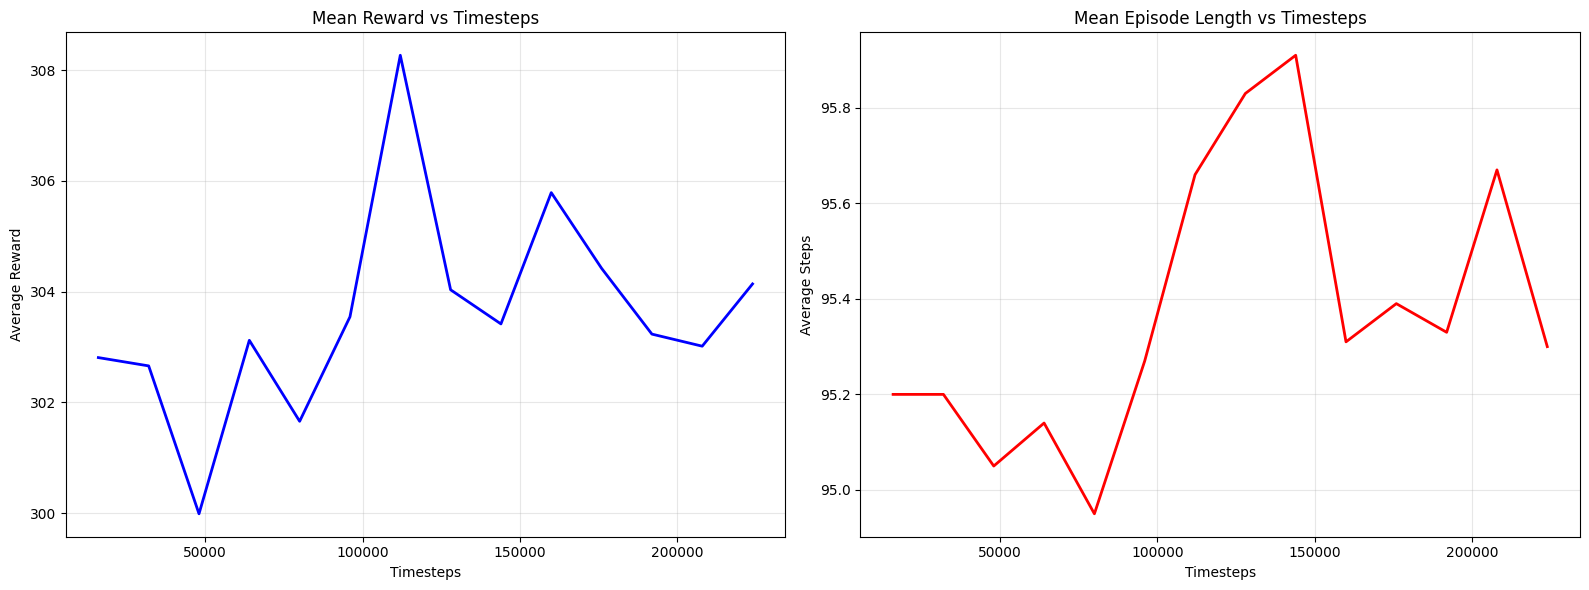

Generating Heatmap...


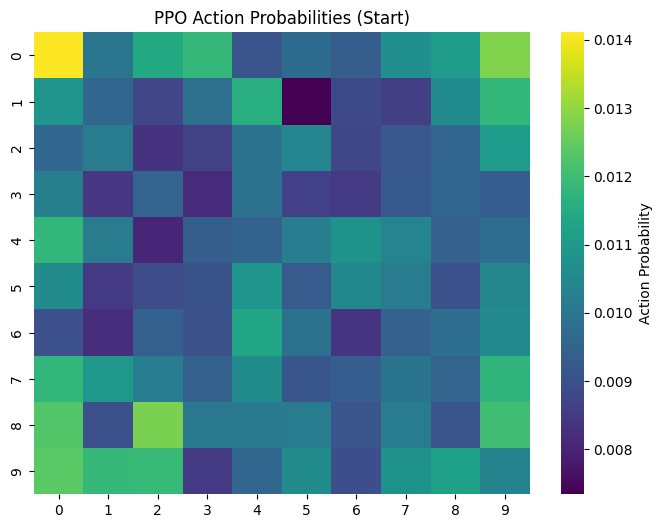

Running Evaluation (Collecting Data)...
Running Evaluation (Games: 1000, Masked: True)...
Running Evaluation (Games: 1000, Masked: False)...


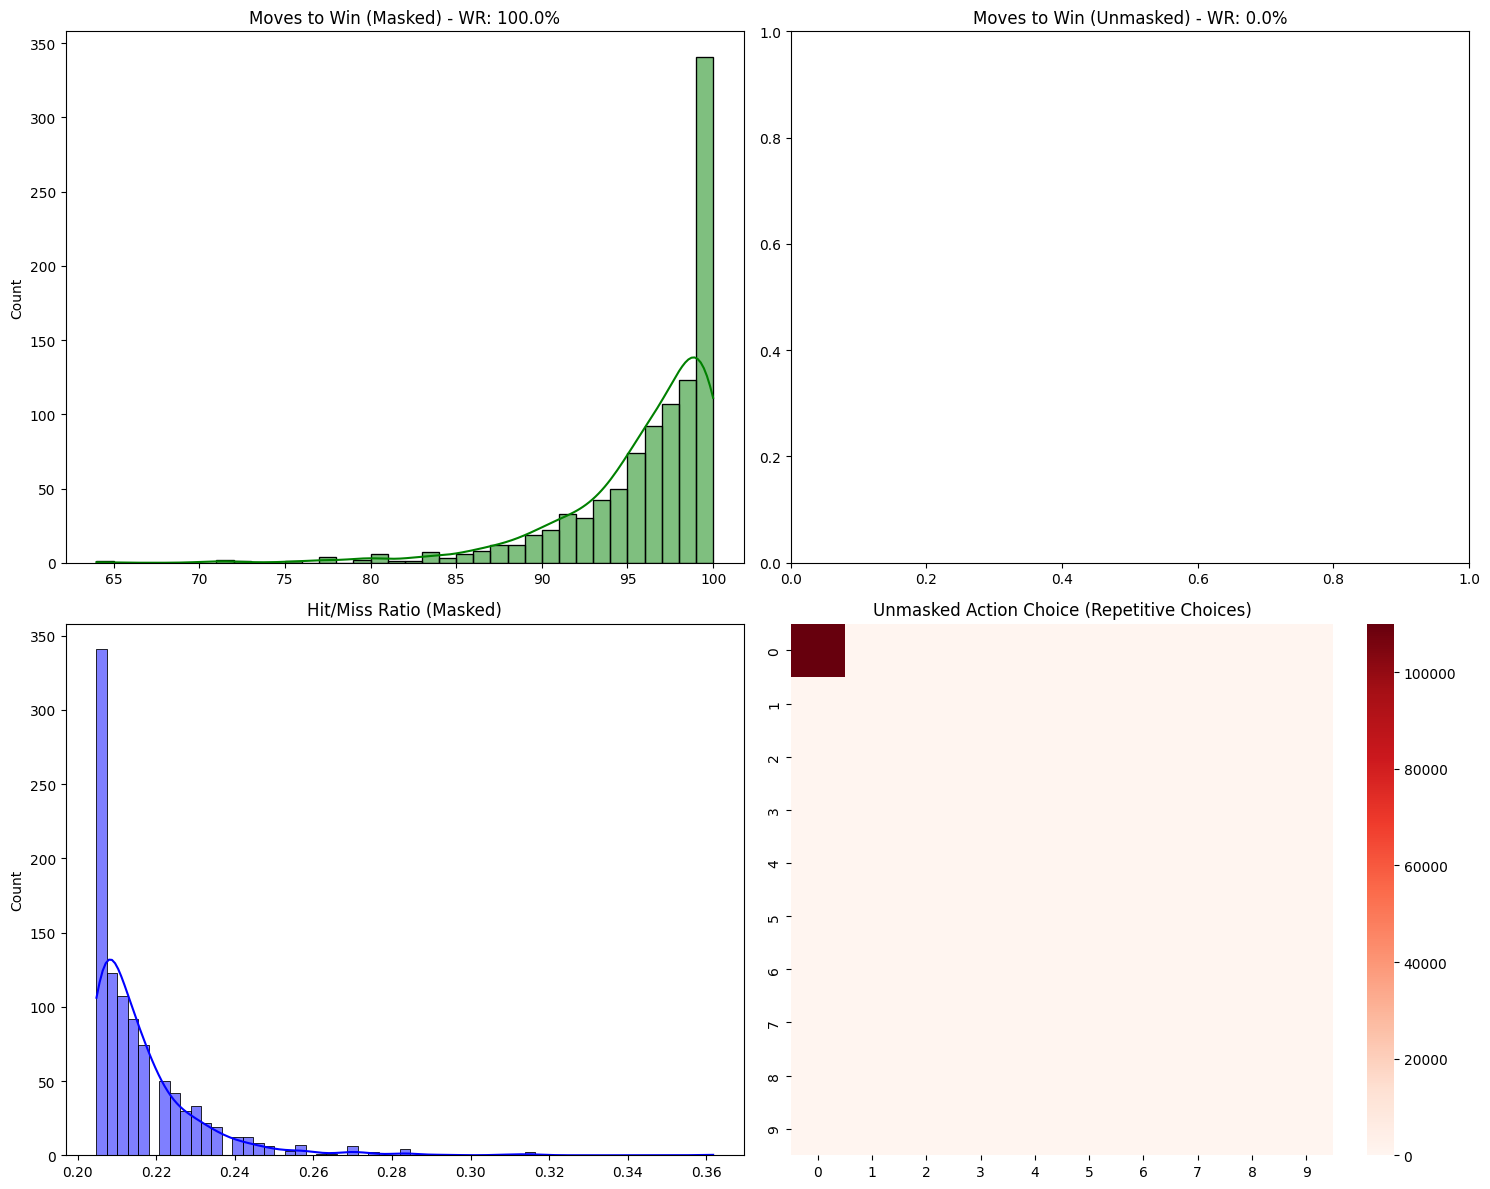

-----------------------------
PPO Model Results (Timesteps: 229376):
  Action Masking Results:
    Win Rate: 100.00%
    Avg Steps (All Games): 95.86
    Avg Reward: 300.85
    Avg Hit/Miss Ratio: 0.22
  Non-Action Masking Results:
    Win Rate: 0.00%
    Avg Steps (All Games): 110.00
    Avg Reward: -2048.43

Stats saved to ppo-training.txt


In [ ]:


import matplotlib.pyplot as plt

def plot_learning_curves_external(callback):
    if not callback.episodes or not callback.ep_rew_means:
        print("No training data found in callback yet.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot Reward
    ax1.plot(callback.episodes, callback.ep_rew_means, 'b-', linewidth=2)
    ax1.set_title("Mean Reward vs Timesteps")
    ax1.set_xlabel("Timesteps")
    ax1.set_ylabel("Average Reward")
    ax1.grid(True, alpha=0.3)
    
    # Plot Episode Length
    ax2.plot(callback.episodes, callback.ep_len_means, 'r-', linewidth=2)
    ax2.set_title("Mean Episode Length vs Timesteps")
    ax2.set_xlabel("Timesteps")
    ax2.set_ylabel("Average Steps")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_learning_curves_external(callback)

eval_env = BattleshipEnv(reward_dictionary=reward_dict, episode_steps=110)

print("Generating Heatmap...")
BattleshipVisualizer.plot_heatmap(model, eval_env, title="PPO Action Probabilities (Start)")

print("Running Evaluation (Collecting Data)...")
evaluator = BattleshipEvaluator(model, eval_env)

masked_results = evaluator.run_evaluation(num_games=1000, mask=True)
unmasked_results = evaluator.run_evaluation(num_games=1000, mask=False)

evaluator.plot_stats(masked_results, unmasked_results)

print_and_save_stats(model, masked_results, unmasked_results)